<font size=10em>Multi-label language classification</font>  
<font size=6em>BERT - TensorFlow 2 & Hugging Face Transformers Library</font>

In [1]:
__author__ = 'takumig'

<font size=4em>abstract</font>  
In this notebook we will learn how to solve the [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).  
The challenge is to determine if a comment taken from a Wikipedia edit discussion can be classified as one or more of the following:  
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

# preparation

## Settings

In [2]:
# setting up kaggle authentication
# Just do one of the following

# -------------------------------------------------------------
# # 1. change permission
# ! chmod 600 ~/.kaggle/kaggle.json

# -------------------------------------------------------------
# 2. set environment variable    <<======== !!choose now!!
import os
import json

with open("~/.kaggle/kaggle.json", mode="r") as f:
    json_data = json.load(f)
os.environ["KAGGLE_USERNAME"] = json_data["username"]
os.environ["KAGGLE_KEY"] = json_data["key"]

FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/kaggle.json'

useing environments
- [Kaggle API](https://github.com/Kaggle/kaggle-api)
- [Docker container registory](https://console.cloud.google.com/gcr/images/kaggle-gpu-images/GLOBAL/python@sha256:7b500f6081e92f812db283da919abe5e305c17a7130d456ddd8ddbd7da786e50/details)
- [GitHub](https://github.com/Kaggle/docker-python/blob/main/Dockerfile.tmpl)  

## Data Preparation

In [ ]:
# # download data using kaggle API
# ! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
# # unzip the downloaded data
# ! unzip jigsaw-toxic-comment-classification-challenge.zip

In [18]:
# If the error occurs in the version, please activate below
!pip install transformers==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 KB 12.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.2/895.2 KB 19.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.1 MB/s eta 0:00:0000:0100:01


In [5]:
# ds library
import numpy as np
import pandas as pd
import tensorflow as tf

# drawing　library
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# others 
from tqdm.notebook import tqdm

2022-03-18 13:00:31.429060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 13:00:31.430110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
df_train = pd.read_csv('train.csv.zip')
df_test = pd.read_csv('test.csv.zip')

# EDA

## overhead view

In [8]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## lavel columns

In [11]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
comments = df_train.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print(f"percent of {i}: {round(100*comments[i].mean(),2)}%")

percent of toxic: 9.58%
percent of severe_toxic: 1.0%
percent of obscene: 5.29%
percent of threat: 0.3%
percent of insult: 4.94%
percent of identity_hate: 0.88%


## comment_colmun

In [13]:
lens = df_train.comment_text.str.len()

print(f"""\
mean: {lens.mean():.2f}\n \
std: {lens.std():.2f}\n \
min: {lens.min()}\n \
max: {lens.max()}\n \
""")

mean: 394.07
 std: 590.72
 min: 6
 max: 5000
 


<AxesSubplot:xlabel='comment_text', ylabel='Count'>

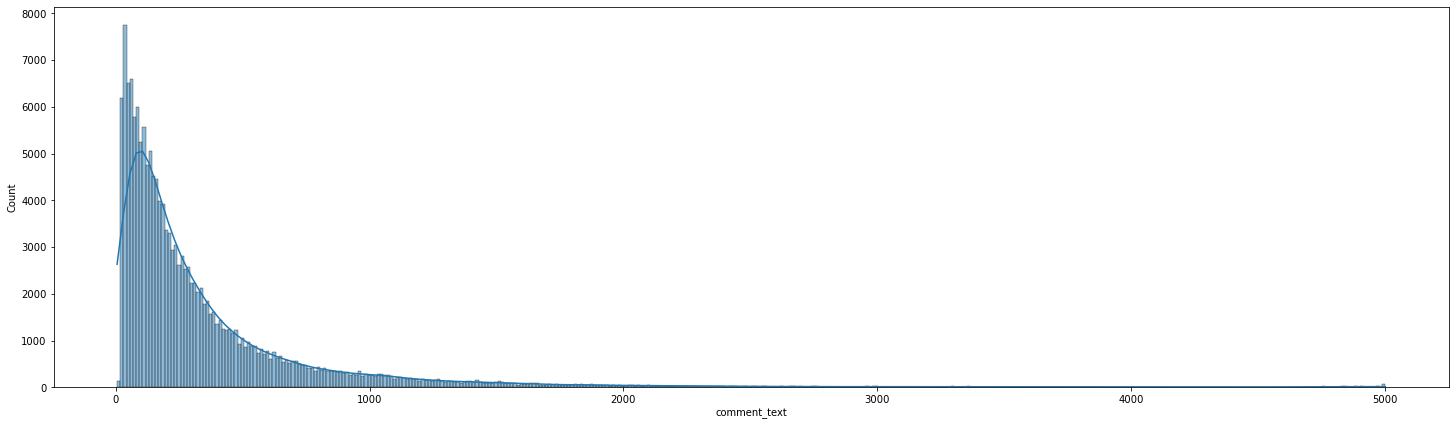

In [14]:
fig, ax = plt.subplots(figsize=(25, 7))
sns.histplot(data=lens, ax=ax, kde=True)

In [15]:
label_cols = [cname for cname in df_train.columns 
              if df_train[cname].dtype == "int64"]
label_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# building the model

## data pipeline
- Preprocessing (Tokenization, Truncation & Padding)
- Creating efficient data pipelines using [tf.data](https://www.tensorflow.org/guide/data).  
- Base model is [bert-base-uncased](https://huggingface.co/bert-base-uncased)
- [Hugging Face Glossaary](https://huggingface.co/docs/transformers/glossary)

In [16]:
df_test_labels = pd.read_csv("test_labels.csv.zip", index_col='id')

In [19]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['comment_text'], tokenizer, MAX_LEN) # Stores encoded body data
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

- Split train test

In [20]:
from sklearn.model_selection import train_test_split

labels =  df_train[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

- Creating dataset using [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [21]:
BATCH_SIZE = 32
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

2022-03-18 13:14:24.999497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-18 13:14:24.999593: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-18 13:14:24.999662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (22775e34faf4): /proc/driver/nvidia/version does not exist
2022-03-18 13:14:25.001767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## BERT model
- Load the pretrained [BERT](https://arxiv.org/pdf/1810.04805.pdf) base-model from Transformers library.
- Take the first hidden-state from BERT output and feed it into a Dense layer with 6 neurons and sigmoid activation. 
- The outputs of this layer can be interpreted as probabilities for each of the 6 classes.
- Better performance with [tf.function](https://www.tensorflow.org/guide/function?hl=en)

In [22]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

## Training Loop
- Use [BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) as loss function
- Use the [AdamW optimizer](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW) with 1-cycle-policy from the Transformers library
- [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean)
- Better performance with [tf.function](https://www.tensorflow.org/guide/function?hl=en)
- AUC evaluation metrics

In [ ]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 0/4487 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.6180324554443359
toxic roc_auc 0.5448718070983887
severe_toxic roc_auc 0.8387097120285034
obscene roc_auc 0.025000005960464478
threat roc_auc 0.0
insult roc_auc 0.44999998807907104
identity_hate roc_auc 0.8064516186714172


# predict & submission

In [ ]:
test_input_ids = tokenize_sentences(df_test['comment_text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

In [ ]:
TEST_BATCH_SIZE = 32
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

df_submission = pd.read_csv("sample_submission.csv.zip", index_col='id')

for i, (token_ids, masks) in enumerate(tqdm(test_dataset, total=test_steps)):
    sample_ids = df_test.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['id']
    predictions = model(token_ids, attention_mask=masks).numpy()

    df_submission.loc[sample_ids, label_cols] = predictions

In [ ]:
df_submission.to_csv('submission.csv')

-  Send a DM to slack when the process is finished.

In [ ]:
# pip install slack_sdk
import json
from slack_sdk import WebClient

with open("slack.json", mode="r") as f:
    json_data = json.load(f)

token = json_data["token"]

client = WebClient(token)
user_id = json_data["user_id"]

res = client.conversations_open(users=user_id)
dm_id = res['channel']['id']

text = "The BERT study and the creation of the CSV file have been completed."
client.chat_postMessage(channel=dm_id, text=text)

In [ ]:
# submit using kaggle api
! kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "Predicted using BERT"

# result

Private Score: 0.98403  
Public Score: 0.98374

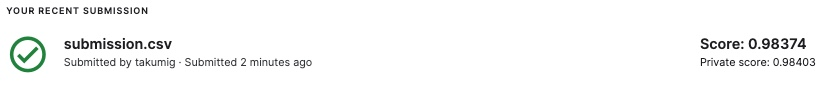

# conclusion

## FYI: Do not use NN

The following results are obtained using NBSVM.  
Features are extracted using Bayes' theorem and then classified by SVM.  
Use logistic regression instead of SVM.  
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)  
code is here -> [NBSVM.ipynb](http://localhost:8888/lab/tree/work/Kaggle/PJ/jigsaw/NBSVM.ipynb)

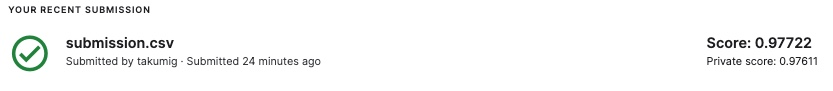

## impressions

Accuracy was greatly improved when BERT was used.  
However, significant costs were incurred.  

 For example, the GPU environment required a GCP environment.  
 Because of time constraints, a high-spec instance was used for this project.  
 The cost was approximately ￥10,000 yen.  
  
In addition, since many methods are provided, implementation was not difficult,  
but I also realized the disadvantage that it is difficult to follow the inner processes.  

If only accuracy is required, such as in kaggle and applications  
I think deep learning is a good way to go.  
I have the impression that it is not suitable for strategic planning in my business.